# SU(4) Staircase Circuit Analysis with KAK Decomposition

- **Circuit Setup**: 6×6 staircase topology with SU(4) gates using KAK decomposition
- **Methods**: Exact truncated Pauli propagation and Monte Carlo sampling
- **Analysis**: Expectation values, MSE convergence, and computational scaling
- **Parameters**: Variable circuit depths (L=1-5) and truncation weights (k=1-4)


In [1]:
import logging, time, json, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

from qiskit.quantum_info import Pauli, Statevector

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli  
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation import staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct # , su4_kak_decomp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from tabulate import tabulate

# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
# plt.rcParams['figure.dpi'] = 300
plt.style.use('default')

### Plotting the actual topology

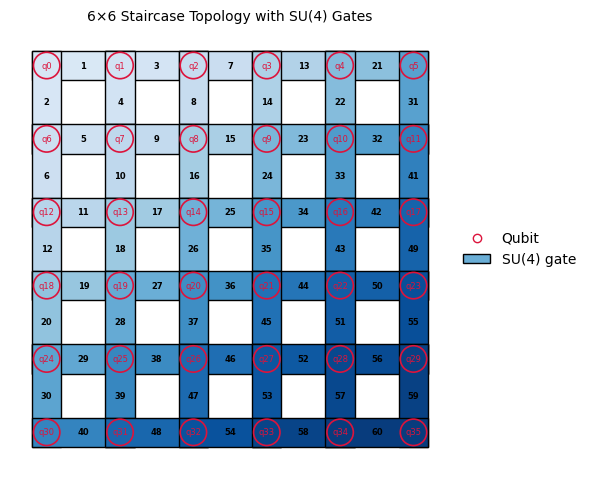

In [2]:
# -------- staircase edge list (1-based indices) ----------
def staircase_edges(nx, ny):
    nxt, tmp, edges = [1], [], []
    while nxt:
        for i in nxt:
            if i % nx:                 # right
                n = i + 1; edges.append((i, n)); tmp.append(n)
            if (i - 1)//nx + 1 < ny:   # down
                n = i + nx; edges.append((i, n)); tmp.append(n)
        nxt, tmp = tmp, []
    uniq, seen = [], set()
    for e in edges:
        if e not in seen:
            seen.add(e); uniq.append(e)
    return uniq
# ---------------------------------------------------------

nx, ny = 6, 6
edges   = staircase_edges(nx, ny)
N       = len(edges)

spacing = 1.          # distance between qubits
long, short = 1.4, 0.4  # gate rectangle sizes

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
ax.axis("off")

# color map light → dark
cmap   = plt.cm.Blues
colors = [cmap(0.15 + 0.8 * i / (N - 1)) for i in range(N)]

# draw SU(4) gate rectangles (bottom layer)
for idx, (q1, q2) in enumerate(edges, 1):
    q1 -= 1; q2 -= 1
    x1, y1 = spacing*(q1 % nx), spacing*(ny - 1 - q1//nx)
    x2, y2 = spacing*(q2 % nx), spacing*(ny - 1 - q2//nx)
    xm, ym = (x1 + x2)/2, (y1 + y2)/2
    if y1 == y2:   # horizontal
        rect = patches.Rectangle((xm - long/2, ym - short/2), long, short,
                                 facecolor=colors[idx-1], edgecolor='k', linewidth=1)
    else:          # vertical
        rect = patches.Rectangle((xm - short/2, ym - long/2), short, long,
                                 facecolor=colors[idx-1], edgecolor='k', linewidth=1)
    ax.add_patch(rect)
    ax.text(xm, ym, str(idx), ha='center', va='center',
            fontsize=6, color='black', weight='bold')

# draw hollow qubit circles with indices (top layer)
circle_radius = 0.18
for q in range(nx*ny):
    x = spacing * (q % nx)
    y = spacing * (ny - 1 - (q // nx))
    circ = patches.Circle((x, y), radius=circle_radius,
                          facecolor='none', edgecolor='crimson', linewidth=1.2)
    ax.add_patch(circ)
    ax.text(x, y, f"q{q}", ha='center', va='center',
            fontsize=6, color='crimson')
# frame limits
pad = 0.5
ax.set_xlim(-pad, spacing*(nx - 1) + pad)
ax.set_ylim(-pad, spacing*(ny - 1) + pad)

qubit_handle = Line2D([0], [0], marker='o', color='w',
                      markerfacecolor='none', markeredgecolor='crimson', linewidth=1.2,
                      label='Qubit')
gate_handle = patches.Patch(facecolor=cmap(0.5), edgecolor='k', label='SU(4) gate')
ax.legend(handles=[qubit_handle, gate_handle],
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.title("6×6 Staircase Topology with SU(4) Gates", fontsize=10)
plt.tight_layout()
plt.show()

### Expectation‐value comparison: Pauli Prop vs. State Vector

In [3]:
# This cell initializes a 2D random su4 staircase quantum and calculates the expectation value.

nx = ny = 6
L = 1

# Initialize the 2D quantum circuit and the initial Pauli term

qc_2d = staircasetopology2d_qc(nx, ny, L)

n = qc_2d.num_qubits
pauli_label = 'Z' + "I" * (n - 1)
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "0" * n
prop_2d = PauliPropagator(qc_2d)

# Propagate the Pauli term through the circuit
history_2d = prop_2d.propagate(init_term, 
                               max_weight=3, 
                               use_parallel=True,
                               history = False)

# Calculate the expectation value
exp_2d = prop_2d.expectation_pauli_sum(history_2d, product_label)
print(exp_2d)

Propagating, max weight: 3:   0%|          | 0/60 [00:00<?, ?it/s]

-0.050649732806362285


In [4]:
# qc_2d.draw(output='mpl', fold=-1);

In [5]:
# KAK reconstruction of the above circuit
qc_2d_kak = su4_kak_reconstruct(qc_2d)

prop_kak_2d = PauliPropagator(qc_2d_kak)

history_kak_2d = prop_kak_2d.propagate(init_term, 
                                       max_weight=3, 
                                       use_parallel=True,
                                       history = False)

exp_kak_2d = prop_kak_2d.expectation_pauli_sum(history_kak_2d, product_label)
print(exp_kak_2d)

Propagating, max weight: 3:   0%|          | 0/900 [00:00<?, ?it/s]

-0.03455695897313906


In [6]:
qc_2d_kak.draw(output='mpl',fold= -1);

In [7]:
# statevector is no longer possible for 6*6 qubit circuits
# sv = Statevector.from_instruction(qc_2d)
# P = Pauli(pauli_label)
# exp_sv = np.real_if_close(sv.expectation_value(P))
# print("Statevector expectation:", exp_sv)

## Runtime plot

In [8]:
# Propagate quantum circuits for L and k, storing results in a JSON file.

nx, ny = 6, 6
k_vals = [1,2,3,4]      # First run [1,2,3]; second run change to [4]
L_vals = [1,2,3,4,5]

for L in L_vals:
    #  Quantum Circuit 
    qc_2d = staircasetopology2d_qc(nx, ny, L)
    qc_2d = su4_kak_reconstruct(qc_2d)
    n = qc_2d.num_qubits
    pauli_label = "X" + "I" * (n - 1)
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    prop_2d = PauliPropagator(qc_2d)

    # Output File 
    output_path = Path(f"results/kak_{nx}_{ny}/prop_results_L{L}.json")
    output_path.parent.mkdir(parents=True, exist_ok=True)

    # Existing file -> Load; otherwise, create an empty skeleton
    if output_path.exists():
        with open(output_path, "r") as f:
            prop_results_dict = json.load(f)
    else:
        prop_results_dict = {"prop_time": {}, "exp_time": {}, "expectation": {}}

    #  Calculate for each k / Supplement 
    for k in k_vals:
        k_str = str(k)  # JSON key is always a string
        if k_str in prop_results_dict["prop_time"]:
            print(f"L={L} with k={k} already exists, skipping")
            continue

        # propagate
        t0 = time.time()
        layers_trunc = prop_2d.propagate(init_term,
                                         max_weight=k,
                                         history=False,
                                         use_parallel=False)
        t_prop = time.time() - t0

        # expectation
        t1 = time.time()
        est_exp = prop_2d.expectation_pauli_sum(layers_trunc, "0" * n)
        t_exp = time.time() - t1

        # Write to the results dictionary
        prop_results_dict["prop_time"][k_str]   = [t_prop]
        prop_results_dict["exp_time"][k_str]    = [t_exp]
        prop_results_dict["expectation"][k_str] = [est_exp]

        print(f"L={L}, k={k} done: prop={t_prop:.2f}s, exp={t_exp:.2f}s")

    with open(output_path, "w") as f:
        json.dump(prop_results_dict, f, indent=2)
    print(f"Results for L={L} saved to {output_path}")

L=1 with k=1 already exists, skipping
L=1 with k=2 already exists, skipping
L=1 with k=3 already exists, skipping
L=1 with k=4 already exists, skipping
Results for L=1 saved to results\kak_6_6\prop_results_L1.json
L=2 with k=1 already exists, skipping
L=2 with k=2 already exists, skipping
L=2 with k=3 already exists, skipping
L=2 with k=4 already exists, skipping
Results for L=2 saved to results\kak_6_6\prop_results_L2.json
L=3 with k=1 already exists, skipping
L=3 with k=2 already exists, skipping
L=3 with k=3 already exists, skipping
L=3 with k=4 already exists, skipping
Results for L=3 saved to results\kak_6_6\prop_results_L3.json
L=4 with k=1 already exists, skipping
L=4 with k=2 already exists, skipping
L=4 with k=3 already exists, skipping
L=4 with k=4 already exists, skipping
Results for L=4 saved to results\kak_6_6\prop_results_L4.json
L=5 with k=1 already exists, skipping
L=5 with k=2 already exists, skipping
L=5 with k=3 already exists, skipping
L=5 with k=4 already exists, s

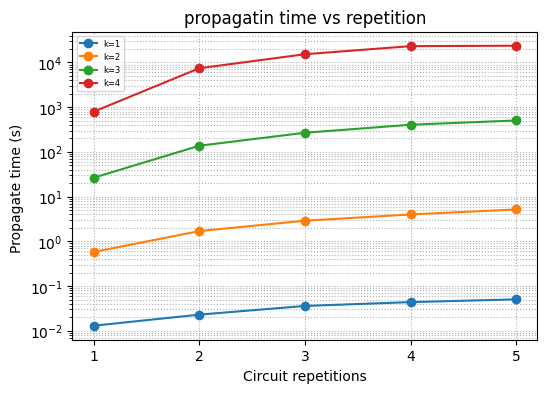

In [9]:
L_vals = [1,2,3,4,5] # L_vals= [1,2,3,4]

# Prepare an empty merged dictionary with the same structure as before
prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
                     'exp_time':     {k: [] for k in k_vals},
                     'expectation':  {k: [] for k in k_vals}}

out_dir_kak = os.path.join("results", f"kak_{nx}_{ny}")
for L in L_vals:
    filename = os.path.join(out_dir_kak, f"prop_results_L{L}.json")
    with open(filename, "r") as f:
        raw = json.load(f)

    # Combine the lists for each metric and k
    for metric, subdict in raw.items():
        for k_str, v_list in subdict.items():
            k = int(k_str)
            prop_results_dict[metric][k].extend(v_list)

# Now prop_results_dict has the exact same format as before,
# with data from all L values merged together.

#  Exact truncation propagate time vs depth (Fig 2(b)), y-axis changed to log10

plt.figure(figsize=(6, 4))
for k in k_vals:
    ts = prop_results_dict['prop_time'][k]
    plt.plot(L_vals, ts, marker='o', label=f'k={k}')
plt.yscale('log')  # Switch to logarithmic scale (base 10)
plt.xlabel('Circuit repetitions')
plt.ylabel('Propagate time (s) ')
plt.title('propagatin time vs repetition')
plt.legend(fontsize = 6)
plt.grid(True, which='both', ls=':')
plt.xticks(L_vals)  # Ensure x-axis only shows integer values
plt.show()

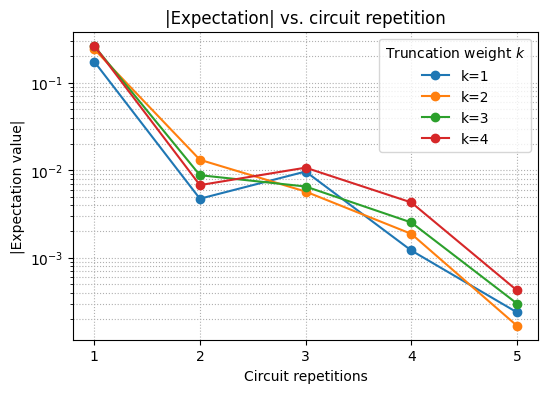

In [10]:
plt.figure(figsize=(6, 4))
for k in k_vals:
    exps = prop_results_dict['expectation'][k]
    abs_exps = [abs(exp) for exp in exps]
    plt.plot(L_vals, abs_exps, marker='o', label=f'k={k}')
plt.yscale('log')
plt.xlabel('Circuit repetitions')
plt.ylabel('|Expectation value|')
plt.title('|Expectation| vs. circuit repetition')
plt.legend(title='Truncation weight $k$')
plt.grid(True, which='both', ls=':')
plt.xticks(L_vals)  # Ensure x-axis only shows integer values
plt.show()


### Monte Carlo

In [11]:

nx, ny = 6,6
L_vals = [1]            
M = int(10000 *51)
max_kk = 6

# Prepare the output directory
out_dir = f"results/kak_{nx}_{ny}"
os.makedirs(out_dir, exist_ok=True)

In [12]:
# WARNING: This cell runs Monte Carlo sampling, 
# results are already saved and will be loaded by subsequent cells.

# for L in L_vals:
#     # Construct circuit & initial PauliTerm 
#     qc_2d = staircasetopology2d_qc(nx, ny, L)
#     qc_2d = su4_kak_reconstruct(qc_2d)
#     n = qc_2d.num_qubits

#     pauli_label = 'Z' + "I" * (n - 1)
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     product_label = "0" * n
#     prop_2d = PauliPropagator(qc_2d)

#     # Monte-Carlo sampling with persistence support 
#     mc = MonteCarlo(qc_2d)
    
#     # Define sample file path for this L
#     sample_file = os.path.join(out_dir, f"kak_samples_L{L}.pkl")
    
#     # Use persistent sampling - will load existing samples if available
#     _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, 
#                                                    M=M, 
#                                                    sample_file=sample_file,
#                                                    load_existing=True)  # Load existing samples
    
#     #  Calculate weight histogram (normalized to probability density) 
#     bins = np.arange(-0.5, n +1+ 0.5)
#     hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)

#     # calculate both it and "probability density" together
#     hist_vals = hist_counts / float(len(last_weights))  # If you also want probability density

#     # Estimate MC MSE for all k 
#     mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
#                                                          product_label=product_label)
        
#     mse   = mse_mc_results_dict['MSE']
#     var = mse_mc_results_dict['Var']

#     # Package the results for this L into a dict, containing only the content for this L ===
#     result_for_L = {"L": L,
#                     "weight_hist": {"hist_vals": hist_vals.tolist(),
#                                     "bin_edges": bin_edges.tolist(),
#                                     "hist_counts": hist_counts.tolist()},
#                     "MSE":  { str(k): float(mse.get(k, 0.0))   for k in range(max_kk + 1)},
#                     "Var":  { str(k): float(var.get(k, 0.0))   for k in range(max_kk + 1)}}

#     # Write to a JSON file, with the value of L in the filename 
#     filename = os.path.join(out_dir, f"kak_mc_results_L{L}.json")
#     with open(filename, 'w') as f:
#         json.dump(result_for_L, f, indent=2, ensure_ascii=False)

#     print(f"Completed MC sampling for L={L}, results saved to：{filename}")

In [13]:
L_vals = [1,2,3,4,5]
mc_results_dict = {"MSE":     { str(k): [] for k in range(max_kk + 1) },
                   "Var":     { str(k): [] for k in range(max_kk + 1) },
                   "weight_hist": {}}

# For each L, open the corresponding JSON file, load the data, and append it to mc_results_dict
for L in L_vals:
    filename = os.path.join(out_dir, f"kak_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    #  Append the single-layer ΔMSE (weight_mse) and cumulative MSE (cum_mse) to their respective lists
    for k in range(max_kk + 1):
        # mc_results_dict["weight_mse"][str(k)].append(data_L["weight_mse"][str(k)])
        mc_results_dict["MSE"][str(k)].append(data_L["MSE"][str(k)])
        mc_results_dict["Var"][str(k)].append(data_L["Var"][str(k)])

    # Also store the histogram "weight_hist": directly use the string of L as the key,
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


In [14]:
# print the table of MSE at differennt circuit repetition and different truncation


table = []
header = ["k"] + [f"rep={L}" for L in [1,2,3,4]]
for k in range(1,5):
    row = [k] + [f"{mc_results_dict['MSE'][str(k)][i]:.4g}" for i in range(4)]
    table.append(row)

print("MSE")
print(tabulate(table, headers=header, tablefmt="grid"))


MSE
+-----+-----------+-----------+-----------+-----------+
|   k |     rep=1 |     rep=2 |     rep=3 |     rep=4 |
+=====+===========+===========+===========+===========+
|   1 | 0.0177    | 0.000734  | 8.6e-05   | 4.595e-06 |
+-----+-----------+-----------+-----------+-----------+
|   2 | 0.001153  | 0.0001    | 2.867e-05 | 1.892e-06 |
+-----+-----------+-----------+-----------+-----------+
|   3 | 0.0004196 | 4.267e-05 | 1.733e-05 | 1.351e-06 |
+-----+-----------+-----------+-----------+-----------+
|   4 | 0.0001608 | 1.133e-05 | 6.667e-07 | 2.703e-07 |
+-----+-----------+-----------+-----------+-----------+


In [15]:
# print the table of MSE at differennt circuit repetition and different truncation


table = []
header = ["k"] + [f"rep={L}" for L in [1,2,3,4]]
for k in range(1,5):
    row = [k] + [f"{np.sqrt(mc_results_dict['Var'][str(k)][i]):.4g}" for i in range(4)]
    table.append(row)

print('Standard Deviation')
print(tabulate(table, headers=header, tablefmt="grid"))


Standard Deviation
+-----+-----------+-----------+-----------+-----------+
|   k |     rep=1 |     rep=2 |     rep=3 |     rep=4 |
+=====+===========+===========+===========+===========+
|   1 | 0.0001846 | 2.211e-05 | 7.572e-06 | 1.114e-06 |
+-----+-----------+-----------+-----------+-----------+
|   2 | 4.752e-05 | 8.165e-06 | 4.372e-06 | 7.151e-07 |
+-----+-----------+-----------+-----------+-----------+
|   3 | 2.868e-05 | 5.333e-06 | 3.399e-06 | 6.043e-07 |
+-----+-----------+-----------+-----------+-----------+
|   4 | 1.775e-05 | 2.749e-06 | 6.667e-07 | 2.703e-07 |
+-----+-----------+-----------+-----------+-----------+


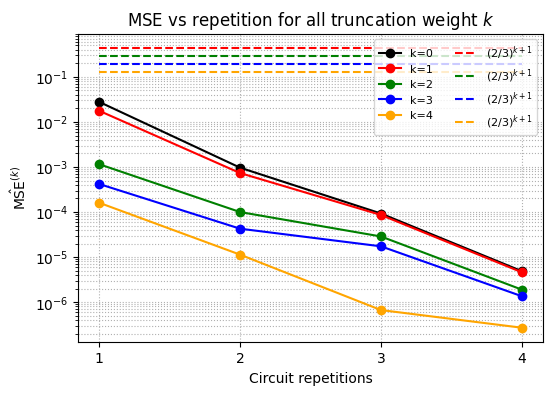

In [16]:
# Fig2(a) MSE vs depth for all truncation thresholds, with theoretical bounds
L_vals_a = [1,2,3,4]
plt.figure(figsize=(6, 4))

colors = ['black', 'red', 'green', 'blue', 'orange']

# plot MSE curves for k = 1..4 with matching colors
for kk, color in zip(range(0, 5), colors):
    ys = mc_results_dict['MSE'][str(kk)]   # list of length len(L_vals)
    plt.plot(L_vals_a, ys[:4], marker='o', color=color, label=f'k={kk}')

# add horizontal dashed lines for (2/3)^(k+1), k=1..4 with same colors
for kk, color in zip(range(1, 5), colors[1:]):
    bound = (2/3)**(kk+1)
    plt.hlines(bound, xmin=min(L_vals_a), xmax=max(L_vals_a),
               colors=color, linestyles='--',
               label=r'$(2/3)^{k+1}$')

plt.yscale('log')
plt.xlabel('Circuit repetitions')
plt.ylabel(r'$\hat{\mathrm{MSE}}^{(k)}$')
plt.title(r'MSE vs repetition for all truncation weight $k$')
plt.legend( ncol=2, fontsize = 8)  
plt.grid(True, which='both', ls=':')
plt.xticks(L_vals_a)  # Force x-axis to show only integer values
plt.show()


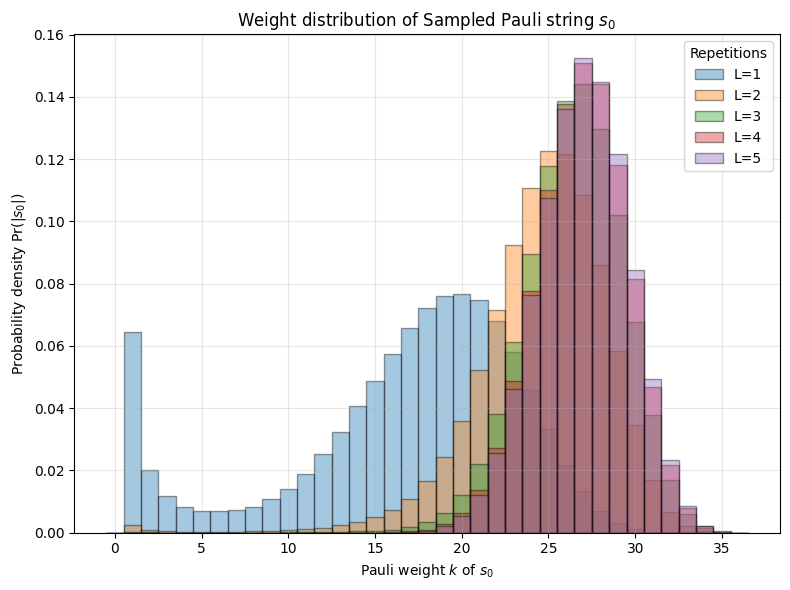

In [17]:
# use a qualitative colormap for distinct but darker edge colors
cmap = plt.get_cmap('tab10')

plt.figure(figsize=(8, 6))
for idx, L in enumerate([1, 2, 3, 4, 5]):
    entry = mc_results_dict['weight_hist'][str(L)]
    hist_vals = entry['hist_vals']
    bin_edges = entry['bin_edges']

    # compute bar widths from bin edges
    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # pick a darker edge color from the colormap
    edge_col = cmap(idx)

    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")


# Inset plot code for contributions of |f_U(P)| (k=1,2,3,4) for repetitions L=1..4

plt.xlabel(r"Pauli weight $k$ of $s_0$")
plt.ylabel(r"Probability density $\Pr(|s_0|)$")
plt.title(r"Weight distribution of Sampled Pauli string $s_0$")
plt.legend(title="Repetitions")
plt.grid(alpha=0.3)
plt.tight_layout()  # Add tight_layout to ensure proper spacing
plt.show()


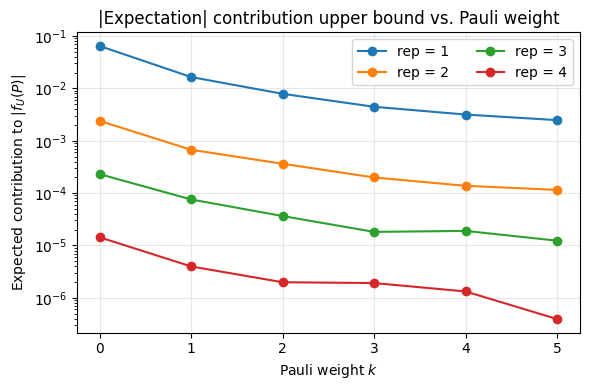

In [18]:
plt.figure(figsize=(6, 4))
cmap = plt.get_cmap("tab10")

# Only use L = 1,2,3,4
for idx, L in enumerate([1, 2, 3, 4]):
    entry      = mc_results_dict["weight_hist"][str(L)]
    hist_vals  = np.asarray(entry["hist_vals"])          # probability p_k
    bin_edges  = np.asarray(entry["bin_edges"])
    weights    = bin_edges[:-1].astype(int)              # k = 0,1,2,...

    # only keep data with k <= 5
    mask = weights <= 5
    weights_filtered = weights[mask]
    hist_vals_filtered = hist_vals[mask]

    # |expectation| contribution: p_k × (2/3)^{k/2}
    # contrib = hist_vals_filtered * (2/3) ** (weights_filtered / 2)
    contrib = hist_vals_filtered * (2/3) ** (weights_filtered/2)
    
    plt.plot(weights_filtered[1:], contrib[1:], marker="o", linestyle="-",
        color=cmap(idx), label=f"rep = {L}")

plt.xlabel(r"Pauli weight $k$")
plt.ylabel(r"Expected contribution to $|f_U(P)|$")
plt.title("|Expectation| contribution upper bound vs. Pauli weight")
plt.yscale('log')
plt.grid(alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()
